多模式多波长光场调制系统 - 训练-仿真集成版 (Zero Padding)
已调整offsets数量以匹配波长数量: 1
✓ 基准波长设置: 索引 0 -> 1550.0nm
配置完成，使用设备: cpu
✓ Zero Padding 配置:
  - Padding ratio: 0.3
  - Use apodization: True
  - Apodization width: 15

阶段1: 数据准备
创建数据生成器...
生成标签...
🔍 标签坐标映射调试:
  MODE 1, WL 1: 中心位置 (40, 40), 区域索引 0
  MODE 1, WL 2: 中心位置 (100, 40), 区域索引 1
  MODE 1, WL 3: 中心位置 (160, 40), 区域索引 2
  MODE 2, WL 1: 中心位置 (40, 100), 区域索引 3
  MODE 2, WL 2: 中心位置 (100, 100), 区域索引 4
  MODE 2, WL 3: 中心位置 (160, 100), 区域索引 5
  MODE 3, WL 1: 中心位置 (40, 160), 区域索引 6
  MODE 3, WL 2: 中心位置 (100, 160), 区域索引 7
  MODE 3, WL 3: 中心位置 (160, 160), 区域索引 8
可视化标签布局...


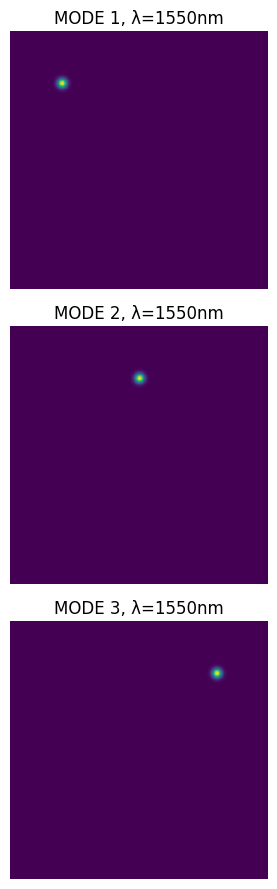

创建评估区域...
🔍 标签坐标映射调试:
  MODE 1, WL 1: 中心位置 (40, 40), 区域索引 0
  MODE 1, WL 2: 中心位置 (100, 40), 区域索引 1
  MODE 1, WL 3: 中心位置 (160, 40), 区域索引 2
  MODE 2, WL 1: 中心位置 (40, 100), 区域索引 3
  MODE 2, WL 2: 中心位置 (100, 100), 区域索引 4
  MODE 2, WL 3: 中心位置 (160, 100), 区域索引 5
  MODE 3, WL 1: 中心位置 (40, 160), 区域索引 6
  MODE 3, WL 2: 中心位置 (100, 160), 区域索引 7
  MODE 3, WL 3: 中心位置 (160, 160), 区域索引 8
✓ 数据准备完成

阶段2: 模型训练 (Zero Padding版本)
开始训练新的Zero Padding模型...
使用外部提供的评估区域: 9个区域

开始训练 1 层模型...
原始数据形状: (50, 50, 55)
选择后的数据形状: (3, 50, 50)
模式 1 振幅范围: 0.0 - 0.10288702696561813
模式 2 振幅范围: 0.0 - 0.0885566994547844
模式 3 振幅范围: 0.0 - 0.0885566994547844
🔍 标签坐标映射调试:
  MODE 1, WL 1: 中心位置 (40, 40), 区域索引 0
  MODE 1, WL 2: 中心位置 (100, 40), 区域索引 1
  MODE 1, WL 3: 中心位置 (160, 40), 区域索引 2
  MODE 2, WL 1: 中心位置 (40, 100), 区域索引 3
  MODE 2, WL 2: 中心位置 (100, 100), 区域索引 4
  MODE 2, WL 3: 中心位置 (160, 100), 区域索引 5
  MODE 3, WL 1: 中心位置 (40, 160), 区域索引 6
  MODE 3, WL 2: 中心位置 (100, 160), 区域索引 7
  MODE 3, WL 3: 中心位置 (160, 160), 区域索引 8
计算波长系数 (基准波长

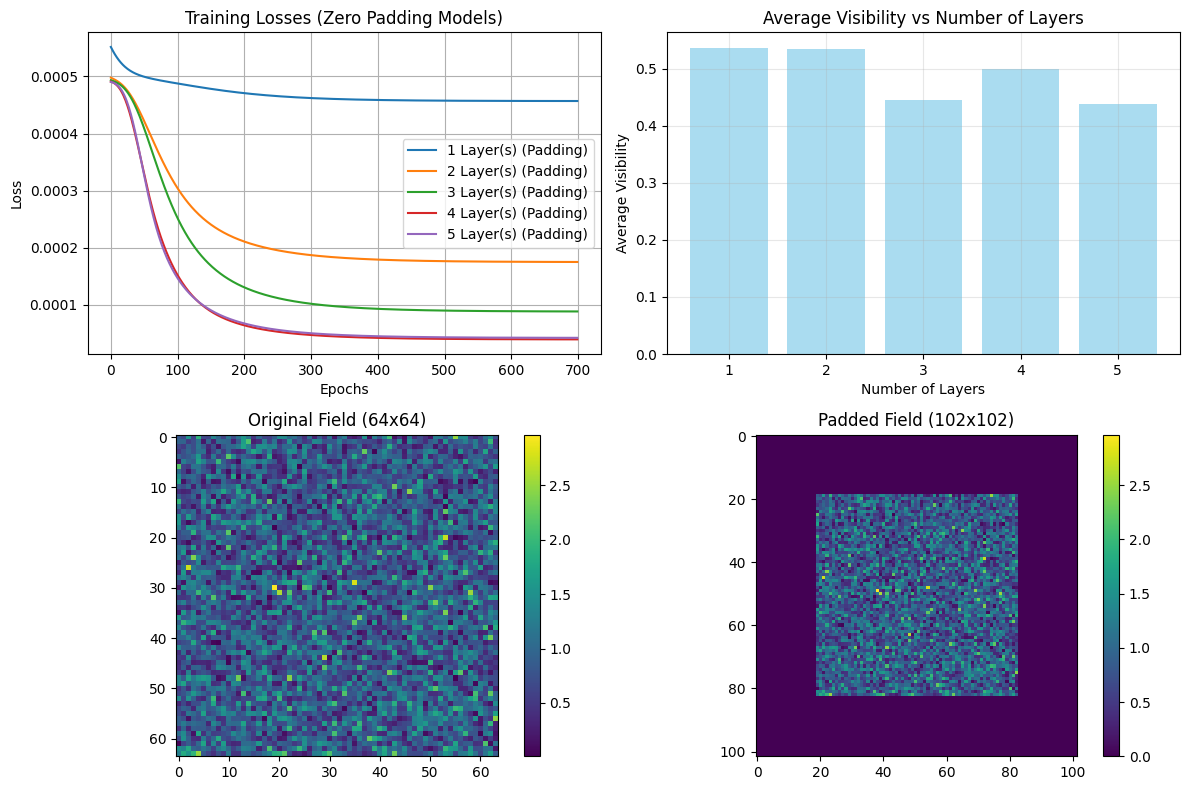


✓ Zero Padding训练完成!
总用时: 194.83 秒
配置已保存到: ./results_multi_mode_multi_wl_1_wavelength_base_1550_dis150//padding_config.json
Padding ratio: 0.3
Use apodization: True


In [ ]:
# -*- coding: utf-8 -*-
"""
多模式多波长光场调制系统 - 主程序（修改版）
集成训练-仿真工作流程 - 使用Zero Padding版本
"""

import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd


from model import MultiModeMultiWavelengthModel, apply_zero_padding
# 导入其他模块
from label_utils import create_evaluation_regions_mode_wavelength, visualize_labels
from config import Config
from data_generator import MultiModeMultiWavelengthDataGenerator
from trainer import Trainer
from simulator import Simulator

start_time = time.time()

# 设置随机种子，确保结果可重现
torch.manual_seed(42)
np.random.seed(42)

print("=" * 60)
print("多模式多波长光场调制系统 - 训练-仿真集成版 (Zero Padding)")
print("=" * 60)

# ===== 掩码加载器类（内联定义）=====
class SimpleMaskLoader:
    """简化的相位掩码加载器"""
    
    def __init__(self, config):
        self.config = config
    
    def create_fallback_masks(self, num_layers=3):
        """创建备用聚焦掩码"""
        print("⚠ 创建备用聚焦掩码...")
        
        def create_focusing_mask(size, wavelength, focal_length, pixel_size):
            center = size // 2
            y, x = np.ogrid[:size, :size]
            r_squared = ((x - center) * pixel_size) ** 2 + ((y - center) * pixel_size) ** 2
            k = 2 * np.pi / wavelength
            phase = -k * r_squared / (2 * focal_length)
            return np.mod(phase, 2 * np.pi)
        
        masks = []
        focal_lengths = [50e-3, 100e-3, 150e-3]  # 不同层的焦距
        
        for layer_idx in range(num_layers):
            layer_masks = []
            for wl_idx, wavelength in enumerate(self.config.wavelengths):
                focal_length = focal_lengths[layer_idx % len(focal_lengths)]
                mask = create_focusing_mask(
                    self.config.layer_size, wavelength, focal_length, self.config.pixel_size
                )
                layer_masks.append(mask)
            masks.append(layer_masks)
        
        print(f"✓ 创建了 {len(masks)} 层备用掩码")
        return masks
    
    def get_masks_for_simulation(self, trained_masks=None, num_layers=3):
        """获取用于仿真的掩码"""
        if trained_masks is not None:
            print("✓ 使用训练好的相位掩码进行仿真")
            return trained_masks
        else:
            print("⚠ 使用备用掩码进行仿真")
            return self.create_fallback_masks(num_layers)

# ===== 修改2: 扩展配置类，添加 Zero Padding 参数 =====
class EnhancedConfig(Config):
    """增强的配置类，添加 Zero Padding 参数"""
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # Zero Padding 参数
        self.padding_ratio = 0.3          # 30% padding
        self.use_apodization = True       # 启用边界衰减
        self.apodization_width = 15       # 衰减宽度
        
        print(f"✓ Zero Padding 配置:")
        print(f"  - Padding ratio: {self.padding_ratio}")
        print(f"  - Use apodization: {self.use_apodization}")
        print(f"  - Apodization width: {self.apodization_width}")

# ===== 修改3: 创建增强配置 =====
config = EnhancedConfig(
    # 基本参数
    num_modes=3,                                # 模式数量
    wavelengths=np.array([1550e-9]),  # 波长列表(m)
    base_wavelength_idx=0,
    # 空间参数
    field_size=50,                              # 场大小(像素)
    layer_size=200,                             # 层大小(像素)
    focus_radius=10,                             # 焦点半径(像素)
    detectsize=15,                              # 检测区域大小(像素)
    
    # 物理参数
    z_layers=40e-6,                             # 层间距离(m)
    z_prop=100e-6,                              # 传播距离(m)
    z_step=20e-6,                               # 传播步长(m)
    pixel_size=1e-6,                            # 像素大小(m)
    
    # 检测区域偏移 - 为每个波长定义不同的偏移
    offsets=[(0,0), (0,0)],           # 每个波长的检测区域偏移
    
    # 训练参数
    learning_rate=0.01,                         # 学习率
    lr_decay=0.99,                              # 学习率衰减
    epochs=700,                                 # 训练轮数
    batch_size=16,                               # 批量大小
    
    # 保存参数
    save_dir="./results_multi_mode_multi_wl_1_wavelength_base_1550_dis150/",  # 修改保存目录名
    flag_savemat=True                           # 是否保存.mat文件
)

# 确保保存目录存在
os.makedirs(config.save_dir, exist_ok=True)
os.makedirs(os.path.join(config.save_dir, "trained_models"), exist_ok=True)

# ===== 修改4: 创建模型的辅助函数 =====
def create_model_with_padding(config, num_layers):
    """创建带有 Zero Padding 的模型"""
    print(f"创建 {num_layers} 层模型 (带 Zero Padding)...")
    
    model = MultiModeMultiWavelengthModel(
        config=config, 
        num_layers=num_layers,
        padding_ratio=config.padding_ratio,
        use_apodization=config.use_apodization,
        apodization_width=config.apodization_width
    )
    
    print(f"✓ 模型创建完成:")
    print(f"  - 层数: {num_layers}")
    print(f"  - Padding ratio: {config.padding_ratio}")
    print(f"  - Use apodization: {config.use_apodization}")
    
    return model

# ===== 修改5: 增强的训练器类 =====
class EnhancedTrainer(Trainer):
    """增强的训练器，支持 Zero Padding 模型"""
    
    def __init__(self, config, data_generator, model_class, evaluation_regions=None):
        # 使用自定义的模型创建函数
        super().__init__(config, data_generator, lambda cfg, nl: create_model_with_padding(cfg, nl), evaluation_regions)
        self.model_class = model_class
    
    def train_single_model(self, num_layers):
        """训练单个模型（重写以支持新模型）"""
        print(f"\n开始训练 {num_layers} 层模型...")
        
        # 创建带 padding 的模型
        model = create_model_with_padding(self.config, num_layers)
        
        # 设置优化器
        optimizer = torch.optim.Adam(model.parameters(), lr=self.config.learning_rate)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=self.config.lr_decay)
        
        # 训练循环
        train_losses = []
        weights_pred_history = []
        visibility_history = []
        
        for epoch in range(self.config.epochs):
            model.train()
            epoch_loss = 0.0
            
            # 生成批次数据
            for batch_idx in range(self.config.batch_size):
                # 生成输入数据
                input_data = self.data_generator.generate_batch_data()
                
                # 前向传播
                optimizer.zero_grad()
                output = model(input_data)
                
                # 计算损失
                target = self.data_generator.get_target_for_batch()
                loss = self.calculate_loss(output, target)
                
                # 反向传播
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
            
            # 记录训练损失
            avg_loss = epoch_loss / self.config.batch_size
            train_losses.append(avg_loss)
            
            # 学习率调度
            scheduler.step()
            
            # 定期评估
            if epoch % 50 == 0:
                print(f"Epoch {epoch}/{self.config.epochs}, Loss: {avg_loss:.6f}")
                
                # 评估可见度
                with torch.no_grad():
                    model.eval()
                    test_input = self.data_generator.generate_batch_data()
                    test_output = model(test_input)
                    visibility = self.evaluate_visibility(test_output)
                    visibility_history.append(visibility)
                    print(f"  平均可见度: {np.mean(visibility):.6f}")
        
        # 保存模型
        model_path = os.path.join(self.config.save_dir, f"model_{num_layers}layers_padding.pth")
        torch.save({
            'model_state_dict': model.state_dict(),
            'train_losses': train_losses,
            'visibility': visibility_history[-1] if visibility_history else [],
            'config': {
                'num_layers': num_layers,
                'padding_ratio': self.config.padding_ratio,
                'use_apodization': self.config.use_apodization,
                'apodization_width': self.config.apodization_width
            }
        }, model_path)
        
        print(f"✓ 模型已保存到: {model_path}")
        
        return {
            'model': model,
            'losses': train_losses,
            'visibility': visibility_history[-1] if visibility_history else [],
            'phase_masks': model.get_phase_masks_for_simulation()
        }

# ===== 阶段1: 数据准备 =====
print("\n" + "="*50)
print("阶段1: 数据准备")
print("="*50)

# 创建数据生成器
print("创建数据生成器...")
data_generator = MultiModeMultiWavelengthDataGenerator(config)

# 生成多模式多波长标签
print("生成标签...")
labels = data_generator.generate_labels()

# 可视化标签布局
print("可视化标签布局...")
visualize_labels(labels, config.wavelengths)

# 创建评估区域
print("创建评估区域...")
evaluation_regions = create_evaluation_regions_mode_wavelength(
    config.layer_size, 
    config.layer_size, 
    config.focus_radius, 
    detectsize=config.detectsize,
    offsets=config.offsets
)

print("✓ 数据准备完成")

# ===== 阶段2: 模型训练 =====
print("\n" + "="*50)
print("阶段2: 模型训练 (Zero Padding版本)")
print("="*50)

# 检查是否存在已训练的模型
trained_models_dir = os.path.join(config.save_dir, "")
existing_models = []
if os.path.exists(trained_models_dir):
    # 查找带 padding 的模型文件
    model_files = [f for f in os.listdir(trained_models_dir) 
                   if f.startswith("model_") and f.endswith("layers_padding.pth")]
    existing_models = [f for f in model_files]

# 定义要训练的层数选项
num_layer_options = [1, 2, 3, 4, 5]

# 询问是否使用现有模型或重新训练
use_existing = False
if existing_models:
    print(f"发现已存在的Zero Padding训练模型: {existing_models}")
    try:
        response = input("是否使用现有模型？(y/n，默认n): ").lower().strip()
        use_existing = response == 'y'
    except:
        print("使用默认选项：重新训练")
        use_existing = False

if use_existing and existing_models:
    print("加载现有Zero Padding训练模型...")
    results = {'models': [], 'losses': [], 'phase_masks': [], 'weights_pred': [], 'visibility': []}
    
    for num_layers in num_layer_options:
        model_path = os.path.join(trained_models_dir, f"model_{num_layers}layers_padding.pth")
        if os.path.exists(model_path):
            print(f"加载 {num_layers} 层Zero Padding模型...")
            
            try:
                # 加载模型检查点
                checkpoint = torch.load(model_path, map_location='cpu')
                
                # 创建带 padding 的模型实例
                model = create_model_with_padding(config, num_layers)
                model.load_state_dict(checkpoint['model_state_dict'])
                
                # 提取相位掩码
                phase_masks = model.get_phase_masks_for_simulation()
                
                # 获取训练数据
                losses = checkpoint.get('train_losses', [])
                weights_pred = checkpoint.get('weights_pred', [])
                visibility = checkpoint.get('visibility', [])
                
                results['models'].append(model)
                results['losses'].append(losses)
                results['phase_masks'].append(phase_masks)
                results['weights_pred'].append(weights_pred)
                results['visibility'].append(visibility)
                
                print(f"✓ 成功加载 {num_layers} 层Zero Padding模型")
                
                # 显示配置信息
                model_config = checkpoint.get('config', {})
                print(f"  - Padding ratio: {model_config.get('padding_ratio', 'N/A')}")
                print(f"  - Use apodization: {model_config.get('use_apodization', 'N/A')}")
                
            except Exception as e:
                print(f"✗ 加载 {num_layers} 层模型失败: {e}")
                # 添加空结果以保持索引一致
                results['models'].append(None)
                results['losses'].append([])
                results['phase_masks'].append([])
                results['weights_pred'].append([])
                results['visibility'].append([])
        else:
            print(f"✗ 未找到 {num_layers} 层Zero Padding模型文件")
            # 添加空结果以保持索引一致
            results['models'].append(None)
            results['losses'].append([])
            results['phase_masks'].append([])
            results['weights_pred'].append([])
            results['visibility'].append([])
else:
    print("开始训练新的Zero Padding模型...")
    
    # 创建增强的训练器
    trainer = EnhancedTrainer(config, data_generator, MultiModeMultiWavelengthModel, evaluation_regions=evaluation_regions)
    
    # 训练多个层数的模型
    results = trainer.train_multiple_models(num_layer_options)

print("✓ Zero Padding模型准备完成")

# ===== 阶段3: 结果分析 =====
print("\n" + "="*50)
print("阶段3: 结果分析 (Zero Padding版本)")
print("="*50)

# 检查可见度数据结构
print("检查训练结果...")
print(f"results键: {list(results.keys())}")
print(f"可见度数据结构: {len(results['visibility'])}层")

valid_results = []
for i, vis_data in enumerate(results['visibility']):
    if vis_data:  # 只处理非空的可见度数据
        expected_length = len(config.wavelengths) * config.num_modes
        print(f"第{i+1}层 ({num_layer_options[i]}层Zero Padding模型):")
        print(f"  数据长度: {len(vis_data)}")
        print(f"  期望长度: {expected_length} ({len(config.wavelengths)}波长 × {config.num_modes}模式)")
        
        if len(vis_data) == expected_length:
            print(f"  ✅ 数据长度匹配！")
            valid_results.append(i)
            # 按波长和模式重新组织显示
            vis_array = np.array(vis_data).reshape(len(config.wavelengths), config.num_modes)
            for wl_idx, wl in enumerate(config.wavelengths):
                wl_nm = wl * 1e9
                print(f"    {wl_nm:.0f}nm: MODE1={vis_array[wl_idx, 0]:.6f}, MODE2={vis_array[wl_idx, 1]:.6f}, MODE3={vis_array[wl_idx, 2]:.6f}")
        else:
            print(f"  ❌ 数据长度不匹配！")
    else:
        print(f"第{i+1}层 ({num_layer_options[i]}层模型): 无可见度数据")

# 可视化训练损失
if results['losses'] and any(results['losses']):
    print("可视化训练损失...")
    plt.figure(figsize=(12, 8))
    
    # 子图1: 训练损失
    plt.subplot(2, 2, 1)
    for i, num_layers in enumerate(num_layer_options):
        if results['losses'][i]:
            plt.plot(results['losses'][i], label=f'{num_layers} Layer(s) (Padding)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Losses (Zero Padding Models)')
    plt.legend()
    plt.grid(True)
    
    # 子图2: 可见度比较
    plt.subplot(2, 2, 2)
    if valid_results:
        layer_nums = [num_layer_options[i] for i in valid_results]
        avg_visibility = [np.mean(results['visibility'][i]) for i in valid_results]
        plt.bar(layer_nums, avg_visibility, alpha=0.7, color='skyblue')
        plt.xlabel('Number of Layers')
        plt.ylabel('Average Visibility')
        plt.title('Average Visibility vs Number of Layers')
        plt.grid(True, alpha=0.3)
    
    # 子图3: Zero Padding 效果展示
    plt.subplot(2, 2, 3)
    # 创建示例数据展示 padding 效果
    example_field = torch.randn(1, 3, 64, 64, dtype=torch.complex64)
    padded_field, _ = apply_zero_padding(example_field, config.padding_ratio)
    
    plt.imshow(torch.abs(example_field[0, 0]).numpy(), cmap='viridis')
    plt.title(f'Original Field (64x64)')
    plt.colorbar()
    
    plt.subplot(2, 2, 4)
    plt.imshow(torch.abs(padded_field[0, 0]).numpy(), cmap='viridis')
    plt.title(f'Padded Field ({padded_field.shape[-1]}x{padded_field.shape[-2]})')
    plt.colorbar()
    
    plt.tight_layout()
    plt.savefig(f"{config.save_dir}/training_results_padding.png", dpi=300)
    plt.show()

# ===== 保存 Zero Padding 配置信息 =====
padding_info = {
    'padding_ratio': config.padding_ratio,
    'use_apodization': config.use_apodization,
    'apodization_width': config.apodization_width,
    'model_type': 'Zero Padding Enhanced',
    'training_time': time.time() - start_time
}

# 保存配置到文件
import json
with open(f"{config.save_dir}/padding_config.json", 'w') as f:
    json.dump(padding_info, f, indent=2)

print(f"\n✓ Zero Padding训练完成!")
print(f"总用时: {time.time() - start_time:.2f} 秒")
print(f"配置已保存到: {config.save_dir}/padding_config.json")
print(f"Padding ratio: {config.padding_ratio}")
print(f"Use apodization: {config.use_apodization}")



阶段4: 光场传播仿真
仿真器初始化完成，使用设备: cpu
开始光场传播仿真...
生成多模式输入场...
✓ 生成输入场完成，形状: torch.Size([3, 1, 50, 50])
  模式数: 3
  波长数: 1
  空间尺寸: 50×50

显示每个模式的光场分布...
Mode 1: Max=0.900, Mean=0.038
Mode 2: Max=0.894, Mean=0.051
Mode 3: Max=0.894, Mean=0.051
✅ 模式图像已保存: ./results_multi_mode_multi_wl_1_wavelength_base_1550_dis150//input_modes_simple.png


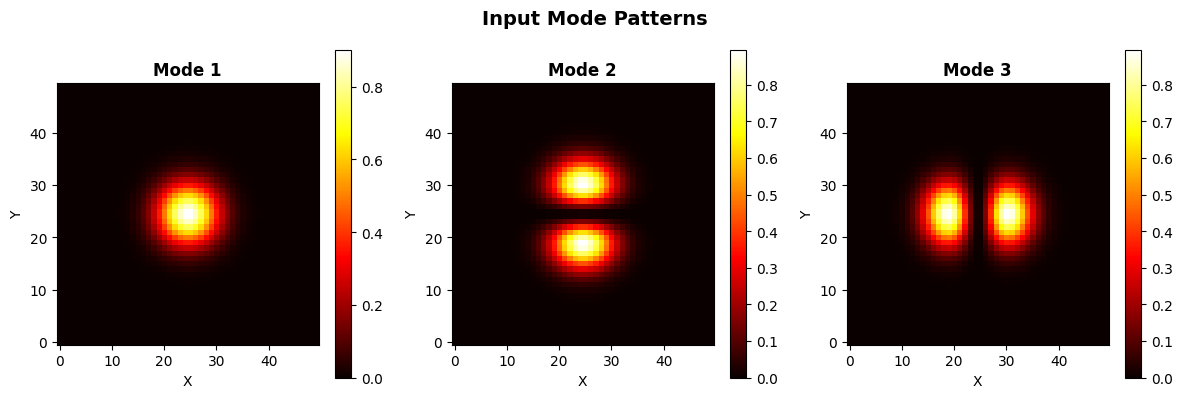

✅ 模式形状显示完成

开始对 5 个不同层数的模型进行仿真...

仿真 1 层模型 (1/5)
✓ 找到对应的训练模型
✓ 使用训练好的 1 层相位掩码
  掩码层数: 1
  每层波长数: 1
  掩码形状示例: (200, 200)
执行光场传播...
  输入场形状: torch.Size([3, 1, 50, 50])
  相位掩码层数: 1
开始光场传播仿真...
🔍 仿真参数调试:
  输入场形状: torch.Size([3, 1, 50, 50])
输入字段维度: 4D, 形状: torch.Size([3, 1, 50, 50])
检测到4D输入 [mode, wavelength, height, width]
模式数: 3, 波长数: 1

🔍 处理模式 1/3 (数组索引: 0)
  模式1输入场形状: torch.Size([1, 50, 50])
    输入场 WL1 (1550nm): 峰值位置 (24, 24)
  使用通用相位掩膜
输入字段维度: 3D, 形状: torch.Size([1, 50, 50])
预处理前场的形状: torch.Size([1, 50, 50])
填充参数: (75, 75, 75, 75)
填充前形状: torch.Size([1, 50, 50])
填充后形状: torch.Size([1, 200, 200])
  λ = 1550 nm
  → 结束

  聚焦质量_mode1:
    质心位置: (91.9, 103.9)
    峰值位置: (53, 55)
    聚焦比例: 0.0089
    峰值强度: 0.038272
✅ Data saved: MC_single_1550nm_mode1_M3_1layers_TestSim_0.0000_20250901_1414.npy (替代 .mat 格式)
🔍 仿真输出分析:
  MODE 1, WL1 (1550nm):
    输出峰值位置: (53, 55)
    期望行位置: ~40 (MODE 1)
    实际行位置: 53
    ✅ 聚焦位置正确
🔍 仿真结果调试:
  MODE 1, WL 1: 峰值位置 (53, 55)
  期望行: 1, 实际峰值行: 53
✓ 模式1仿真完成，生成1个评估结果

🔍 

In [12]:
# ===== 阶段4: 光场传播仿真 =====
import numpy as np
import matplotlib.pyplot as plt

print("\n" + "="*50)
print("阶段4: 光场传播仿真")
print("="*50)

# 创建掩码加载器
mask_loader = SimpleMaskLoader(config)

# 创建仿真器
simulator = Simulator(config, evaluation_regions=evaluation_regions)

print("开始光场传播仿真...")

# **关键修复：只生成一次输入场，供所有模型使用**
print("生成多模式输入场...")
try:
    input_fields = data_generator.generate_input_data()
    print(f"✓ 生成输入场完成，形状: {input_fields.shape}")
    print(f"  模式数: {input_fields.shape[0]}")
    print(f"  波长数: {input_fields.shape[1]}")
    print(f"  空间尺寸: {input_fields.shape[2]}×{input_fields.shape[3]}")
except Exception as e:
    print(f"❌ 生成输入场失败: {e}")
    input_fields = None

# 显示每个模式的光场分布
if 'input_fields' in locals() and input_fields is not None:
    print("\n显示每个模式的光场分布...")
    
    try:
        num_modes = input_fields.shape[0]
        num_wavelengths = input_fields.shape[1]
        
        # 创建简单的模式显示图
        fig, axes = plt.subplots(1, num_modes, figsize=(4*num_modes, 4))
        if num_modes == 1:
            axes = [axes]
        
        fig.suptitle('Input Mode Patterns', fontsize=14, fontweight='bold')
        
        # 使用第一个波长显示每个模式
        for mode_idx in range(num_modes):
            display_mode = mode_idx + 1
            
            # 获取该模式的光场
            field = input_fields[mode_idx, 0]  # 使用第一个波长
            
            # 转换为numpy数组并计算强度
            if hasattr(field, 'cpu'):  # 如果是PyTorch张量
                field_np = field.cpu().numpy()
            elif hasattr(field, 'numpy'):  # 如果是其他张量类型
                field_np = field.numpy()
            else:
                field_np = np.array(field)
            
            intensity = np.abs(field_np)**2
            
            # 显示强度分布
            im = axes[mode_idx].imshow(intensity, cmap='hot', origin='lower')
            axes[mode_idx].set_title(f'Mode {display_mode}', fontweight='bold')
            axes[mode_idx].set_xlabel('X')
            axes[mode_idx].set_ylabel('Y')
            
            # 添加颜色条
            plt.colorbar(im, ax=axes[mode_idx])
            
            # 打印模式信息
            max_intensity = np.max(intensity)
            mean_intensity = np.mean(intensity)
            print(f"Mode {display_mode}: Max={max_intensity:.3f}, Mean={mean_intensity:.3f}")
        
        plt.tight_layout()
        
        # 保存图像
        modes_save_path = f"{config.save_dir}/input_modes_simple.png"
        plt.savefig(modes_save_path, dpi=300, bbox_inches='tight')
        print(f"✅ 模式图像已保存: {modes_save_path}")
        
        # 显示图像
        plt.show()
        
        print("✅ 模式形状显示完成")
        
    except Exception as e:
        print(f"❌ 模式显示失败: {e}")
        import traceback
        traceback.print_exc()
        
else:
    print("❌ 没有找到输入光场数据")

# 选择要仿真的模型
simulation_results = {}

# 检查是否有有效的输入场
if input_fields is None:
    print("❌ 无法进行仿真：输入场生成失败")
else:
    print(f"\n开始对 {len(num_layer_options)} 个不同层数的模型进行仿真...")
    
    for i, num_layers in enumerate(num_layer_options):
        print(f"\n{'='*60}")
        print(f"仿真 {num_layers} 层模型 ({i+1}/{len(num_layer_options)})")
        print(f"{'='*60}")
        
        try:
            # 检查是否有对应的训练模型
            if i < len(results['models']) and results['models'][i] is not None:
                print(f"✓ 找到对应的训练模型")
                
                # 获取训练好的相位掩码
                if i < len(results['phase_masks']) and results['phase_masks'][i]:
                    phase_masks = results['phase_masks'][i]
                    print(f"✓ 使用训练好的 {num_layers} 层相位掩码")
                    print(f"  掩码层数: {len(phase_masks)}")
                    if phase_masks:
                        print(f"  每层波长数: {len(phase_masks[0]) if phase_masks[0] else 0}")
                        print(f"  掩码形状示例: {phase_masks[0][0].shape if phase_masks[0] and len(phase_masks[0]) > 0 else 'N/A'}")
                else:
                    # 使用备用掩码
                    print(f"⚠️  未找到训练好的掩码，使用备用掩码")
                    phase_masks = mask_loader.get_masks_for_simulation(None, num_layers)
                    print(f"  生成备用 {num_layers} 层相位掩码")
                
                # 执行仿真
                print("执行光场传播...")
                print(f"  输入场形状: {input_fields.shape}")
                print(f"  相位掩码层数: {len(phase_masks) if phase_masks else 0}")
                
                propagation_results = simulator.simulate_propagation(
                    phase_masks=phase_masks,
                    input_field=input_fields,  # 使用同一个输入场
                    process_all_modes=True
                )
                
                # 验证仿真结果
                print(f"\n仿真结果验证:")
                if propagation_results:
                    print(f"  ✅ 结果数量: {len(propagation_results)}")
                    
                    # 按模式统计结果
                    mode_counts = {}
                    wavelength_counts = {}
                    
                    for result in propagation_results:
                        if isinstance(result, dict):
                            mode_idx = result.get('mode_idx', 0)
                            wl_idx = result.get('wavelength_idx', 0)
                            
                            mode_counts[mode_idx] = mode_counts.get(mode_idx, 0) + 1
                            wavelength_counts[wl_idx] = wavelength_counts.get(wl_idx, 0) + 1
                    
                    print(f"  模式分布: {mode_counts}")
                    print(f"  波长分布: {wavelength_counts}")
                    
                    # 显示前几个结果的详细信息
                    print(f"  前6个结果详情:")
                    for idx, result in enumerate(propagation_results[:6]):
                        if isinstance(result, dict):
                            mode_idx = result.get('mode_idx', 0)  # 内部索引 0-2
                            wl_idx = result.get('wavelength_idx', 0)
                            focus_ratio = result.get('focus_ratio', 0)
                            peak_intensity = result.get('peak_intensity', 0)
                            
                            # 获取波长值
                            if wl_idx < len(config.wavelengths):
                                wl_nm = config.wavelengths[wl_idx] * 1e9
                            else:
                                wl_nm = 0
                            
                            # 显示标签使用 mode_idx+1，保持与图表一致
                            display_mode = mode_idx + 1  # 转换为显示标签 1-3
                            
                            print(f"    结果{idx+1}: 模式{display_mode}, {wl_nm:.0f}nm, "
                                  f"聚焦比例={focus_ratio:.4f}, 峰值={peak_intensity:.6f}")
                    
                    # 计算平均性能指标
                    focus_ratios = [r.get('focus_ratio', 0) for r in propagation_results if isinstance(r, dict)]
                    peak_intensities = [r.get('peak_intensity', 0) for r in propagation_results if isinstance(r, dict)]
                    
                    if focus_ratios:
                        avg_focus = np.mean(focus_ratios)
                        avg_peak = np.mean(peak_intensities)
                        print(f"  平均聚焦比例: {avg_focus:.4f}")
                        print(f"  平均峰值强度: {avg_peak:.6f}")
                
                else:
                    print(f"  ❌ 无仿真结果")
                
                # 保存仿真结果
                simulation_results[num_layers] = propagation_results
                
                print(f"✅ {num_layers} 层模型仿真完成")
                
            else:
                print(f"⚠️  跳过 {num_layers} 层模型：未找到对应的训练模型")
                simulation_results[num_layers] = []
                
        except Exception as e:
            print(f"❌ {num_layers} 层模型仿真失败: {e}")
            import traceback
            traceback.print_exc()
            simulation_results[num_layers] = []
            continue

# 验证所有仿真结果
print(f"\n{'='*50}")
print("仿真结果总览")
print(f"{'='*50}")

total_results = 0
successful_simulations = 0

for num_layers, results_list in simulation_results.items():
    count = len(results_list) if results_list else 0
    total_results += count
    if count > 0:
        successful_simulations += 1
    
    status = "✅" if count > 0 else "❌"
    print(f"{status} {num_layers}层模型: {count}个结果")

expected_results = len(num_layer_options) * config.num_modes * len(config.wavelengths)
print(f"\n📊 统计信息:")
print(f"  成功仿真的模型: {successful_simulations}/{len(num_layer_options)}")
print(f"  总仿真结果数: {total_results}")
print(f"  期望结果数: {expected_results}")
print(f"  完成率: {(total_results/expected_results*100):.1f}%" if expected_results > 0 else "  完成率: N/A")

# 保存仿真结果摘要
try:
    import json
    summary = {
        'timestamp': str(pd.Timestamp.now()),
        'total_models': len(num_layer_options),
        'successful_simulations': successful_simulations,
        'total_results': total_results,
        'expected_results': expected_results,
        'completion_rate': (total_results/expected_results) if expected_results > 0 else 0,
        'layer_results': {str(k): len(v) if v else 0 for k, v in simulation_results.items()}
    }
    
    summary_path = f"{config.save_dir}/simulation_summary.json"
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)
    print(f"📄 仿真摘要已保存: {summary_path}")
    
except Exception as e:
    print(f"⚠️  保存仿真摘要失败: {e}")

if total_results > 0:
    print("✅ 光场传播仿真完成")
else:
    print("❌ 光场传播仿真未产生有效结果")

print(f"\n💾 所有结果保存在: {config.save_dir}")



阶段4.5: 仿真结果可视化分析
开始创建分离的Cross Matrix和SNR分析可视化...

1. 创建传播结果总结图...
创建不同层数的传播结果汇总图...
找到 15 个仿真结果文件

创建 1 层模型的汇总图...
Creating summary for 1-layer model, containing 3 result(s)...
  Loading file: MC_single_1550nm_mode1_M3_1layers_TestSim_0.0000_20250901_1414.npy
    ✓ Loaded and displayed successfully
  Loading file: MC_single_1550nm_mode2_M3_1layers_TestSim_0.0000_20250901_1414.npy
    ✓ Loaded and displayed successfully
  Loading file: MC_single_1550nm_mode3_M3_1layers_TestSim_0.0000_20250901_1414.npy
    ✓ Loaded and displayed successfully


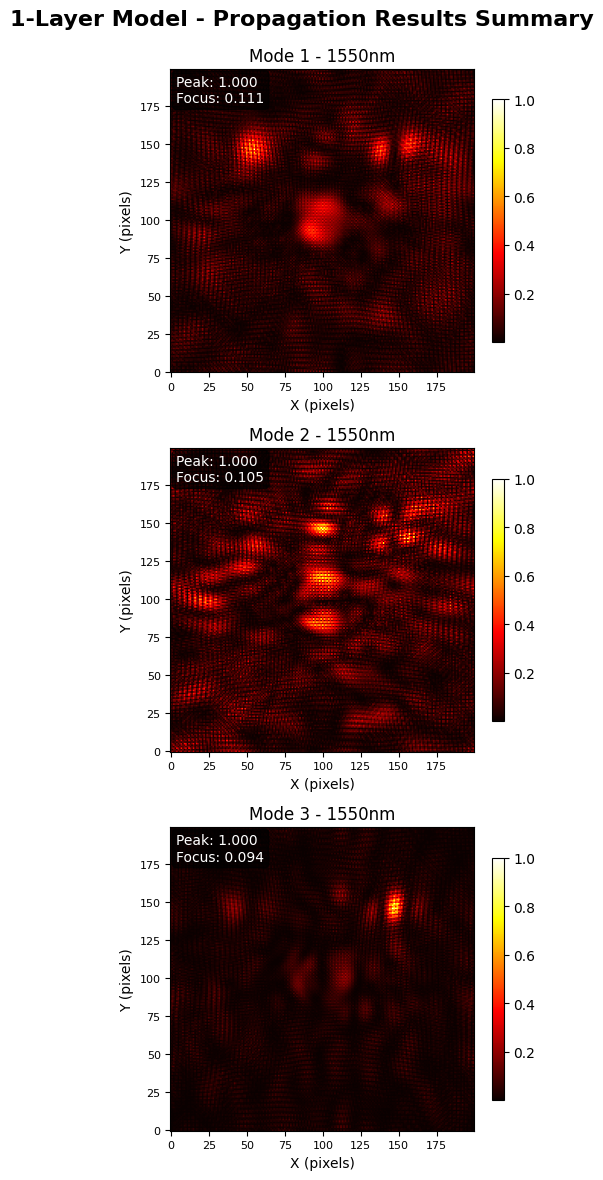

✅ 1 层模型汇总图已保存: ./results_multi_mode_multi_wl_1_wavelength_base_1550_dis150/1_layers_propagation_summary.png
   成功加载 3/3 个文件

创建 2 层模型的汇总图...
Creating summary for 2-layer model, containing 3 result(s)...
  Loading file: MC_single_1550nm_mode1_M3_2layers_TestSim_0.0000_20250901_1414.npy
    ✓ Loaded and displayed successfully
  Loading file: MC_single_1550nm_mode2_M3_2layers_TestSim_0.0000_20250901_1414.npy
    ✓ Loaded and displayed successfully
  Loading file: MC_single_1550nm_mode3_M3_2layers_TestSim_0.0000_20250901_1414.npy
    ✓ Loaded and displayed successfully


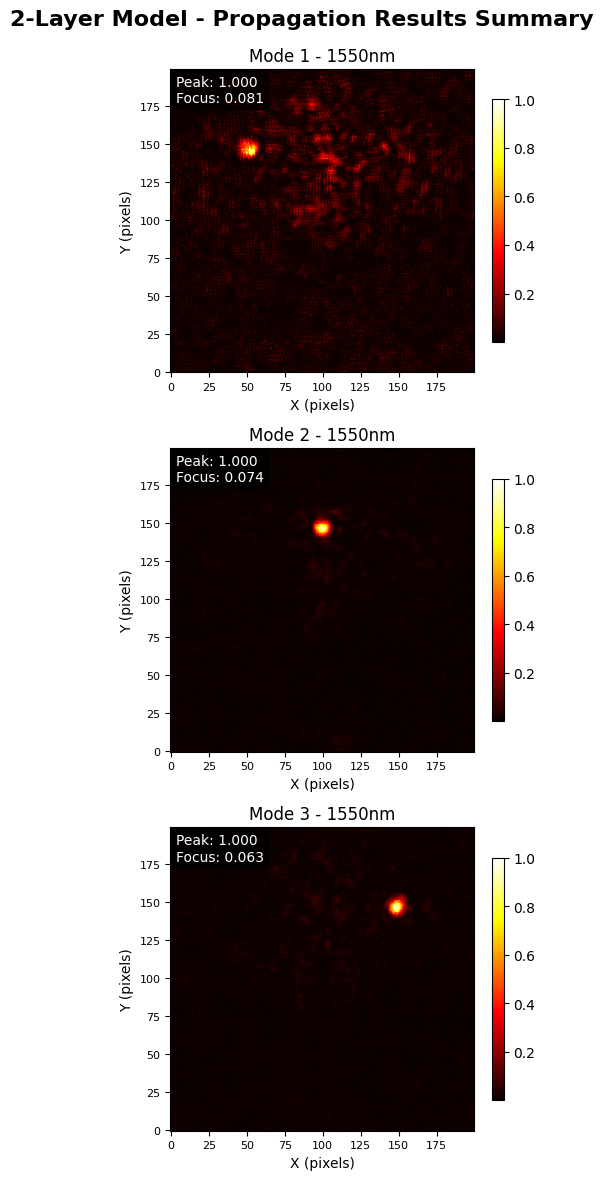

✅ 2 层模型汇总图已保存: ./results_multi_mode_multi_wl_1_wavelength_base_1550_dis150/2_layers_propagation_summary.png
   成功加载 3/3 个文件

创建 3 层模型的汇总图...
Creating summary for 3-layer model, containing 3 result(s)...
  Loading file: MC_single_1550nm_mode1_M3_3layers_TestSim_0.0000_20250901_1414.npy
    ✓ Loaded and displayed successfully
  Loading file: MC_single_1550nm_mode2_M3_3layers_TestSim_0.0000_20250901_1414.npy
    ✓ Loaded and displayed successfully
  Loading file: MC_single_1550nm_mode3_M3_3layers_TestSim_0.0000_20250901_1414.npy
    ✓ Loaded and displayed successfully


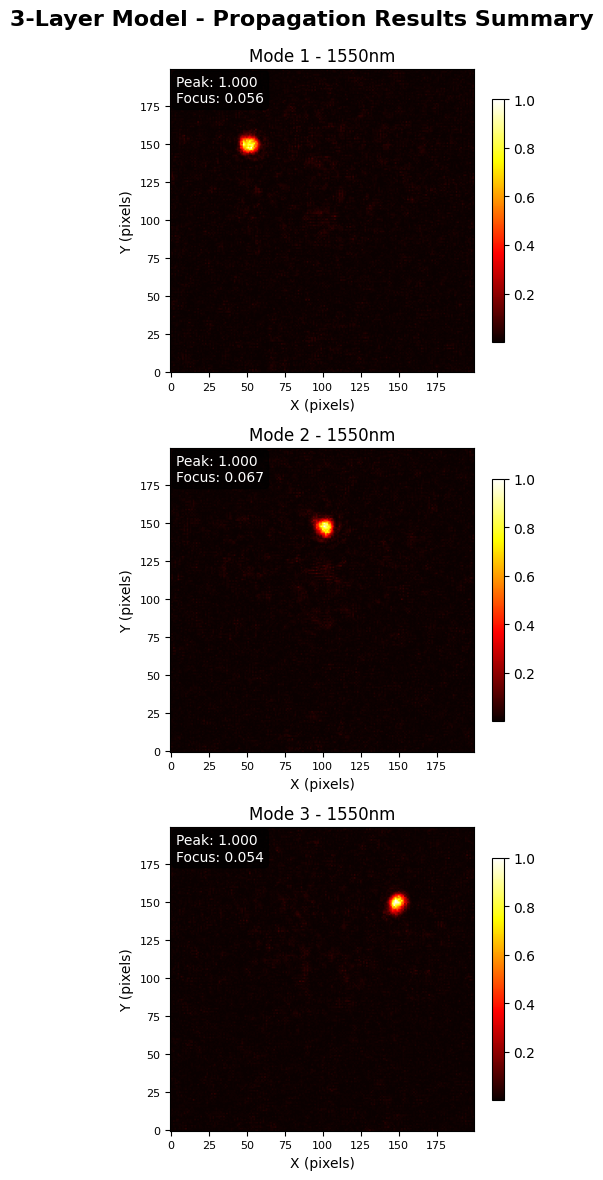

✅ 3 层模型汇总图已保存: ./results_multi_mode_multi_wl_1_wavelength_base_1550_dis150/3_layers_propagation_summary.png
   成功加载 3/3 个文件

创建 4 层模型的汇总图...
Creating summary for 4-layer model, containing 3 result(s)...
  Loading file: MC_single_1550nm_mode1_M3_4layers_TestSim_0.0000_20250901_1414.npy
    ✓ Loaded and displayed successfully
  Loading file: MC_single_1550nm_mode2_M3_4layers_TestSim_0.0000_20250901_1414.npy
    ✓ Loaded and displayed successfully
  Loading file: MC_single_1550nm_mode3_M3_4layers_TestSim_0.0000_20250901_1414.npy
    ✓ Loaded and displayed successfully


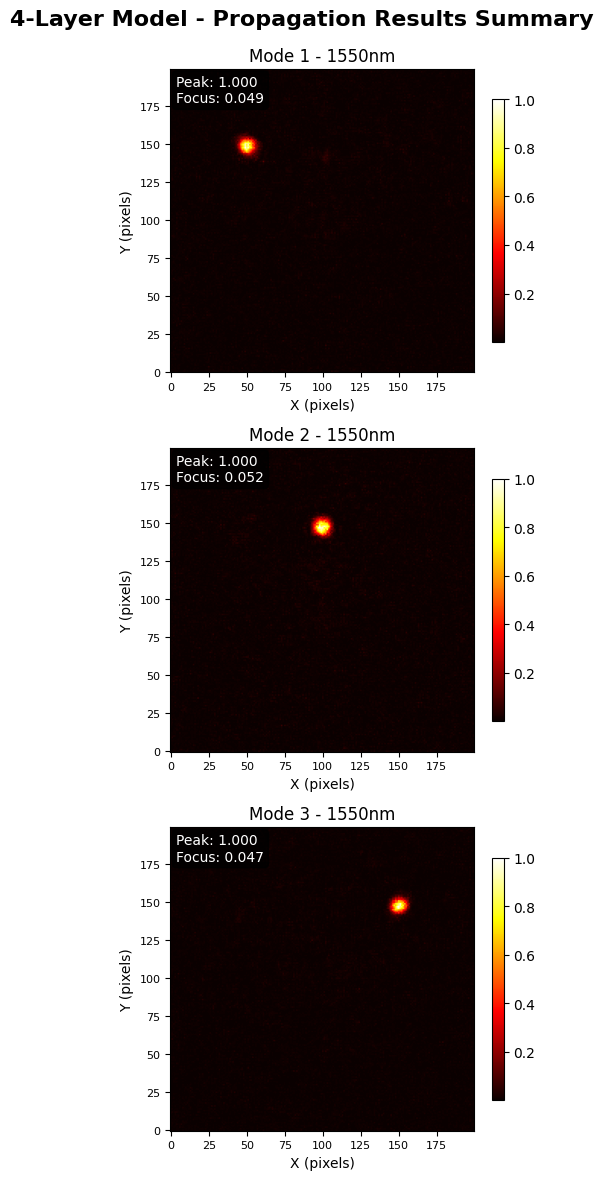

✅ 4 层模型汇总图已保存: ./results_multi_mode_multi_wl_1_wavelength_base_1550_dis150/4_layers_propagation_summary.png
   成功加载 3/3 个文件

创建 5 层模型的汇总图...
Creating summary for 5-layer model, containing 3 result(s)...
  Loading file: MC_single_1550nm_mode1_M3_5layers_TestSim_0.0000_20250901_1414.npy
    ✓ Loaded and displayed successfully
  Loading file: MC_single_1550nm_mode2_M3_5layers_TestSim_0.0000_20250901_1414.npy
    ✓ Loaded and displayed successfully
  Loading file: MC_single_1550nm_mode3_M3_5layers_TestSim_0.0000_20250901_1414.npy
    ✓ Loaded and displayed successfully


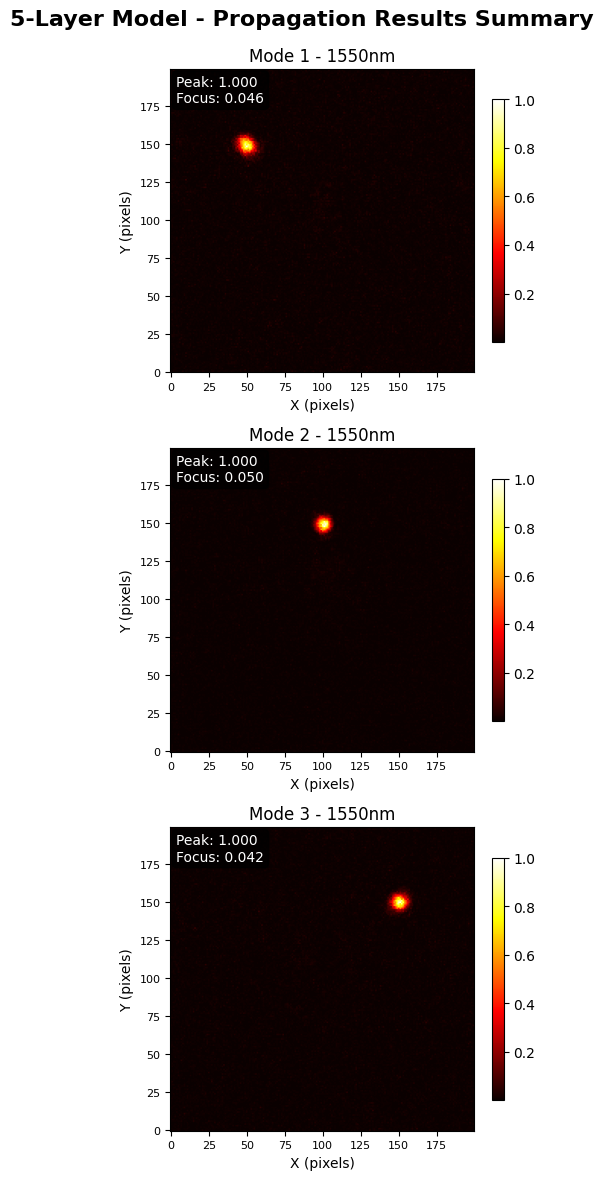

✅ 5 层模型汇总图已保存: ./results_multi_mode_multi_wl_1_wavelength_base_1550_dis150/5_layers_propagation_summary.png
   成功加载 3/3 个文件

2. 初始化可视化器...

3. 使用分离的双维度可视化分析...
   📊 创建分离的Cross Matrix和SNR分析...
📊 创建分离的双维度分析报告...
🔍 分别计算Cross Matrix和SNR数据...
找到 15 个仿真结果文件
🔍 解析文件名: MC_single_1550nm_mode2_M3_4layers_TestSim_0.0000_20250901_1414.npy
  L4_M2_1550nm: Cross=0.324, SNR=9.05dB
🔍 解析文件名: MC_single_1550nm_mode1_M3_5layers_TestSim_0.0000_20250901_1414.npy
  L5_M1_1550nm: Cross=0.329, SNR=8.93dB
🔍 解析文件名: MC_single_1550nm_mode2_M3_5layers_TestSim_0.0000_20250901_1414.npy
  L5_M2_1550nm: Cross=0.341, SNR=9.32dB
🔍 解析文件名: MC_single_1550nm_mode3_M3_3layers_TestSim_0.0000_20250901_1414.npy
  L3_M3_1550nm: Cross=0.259, SNR=8.73dB
🔍 解析文件名: MC_single_1550nm_mode2_M3_3layers_TestSim_0.0000_20250901_1414.npy
  L3_M2_1550nm: Cross=0.413, SNR=8.57dB
🔍 解析文件名: MC_single_1550nm_mode3_M3_4layers_TestSim_0.0000_20250901_1414.npy
  L4_M3_1550nm: Cross=0.388, SNR=9.11dB
🔍 解析文件名: MC_single_1550nm_mode2_M3_1layers_TestSim_0

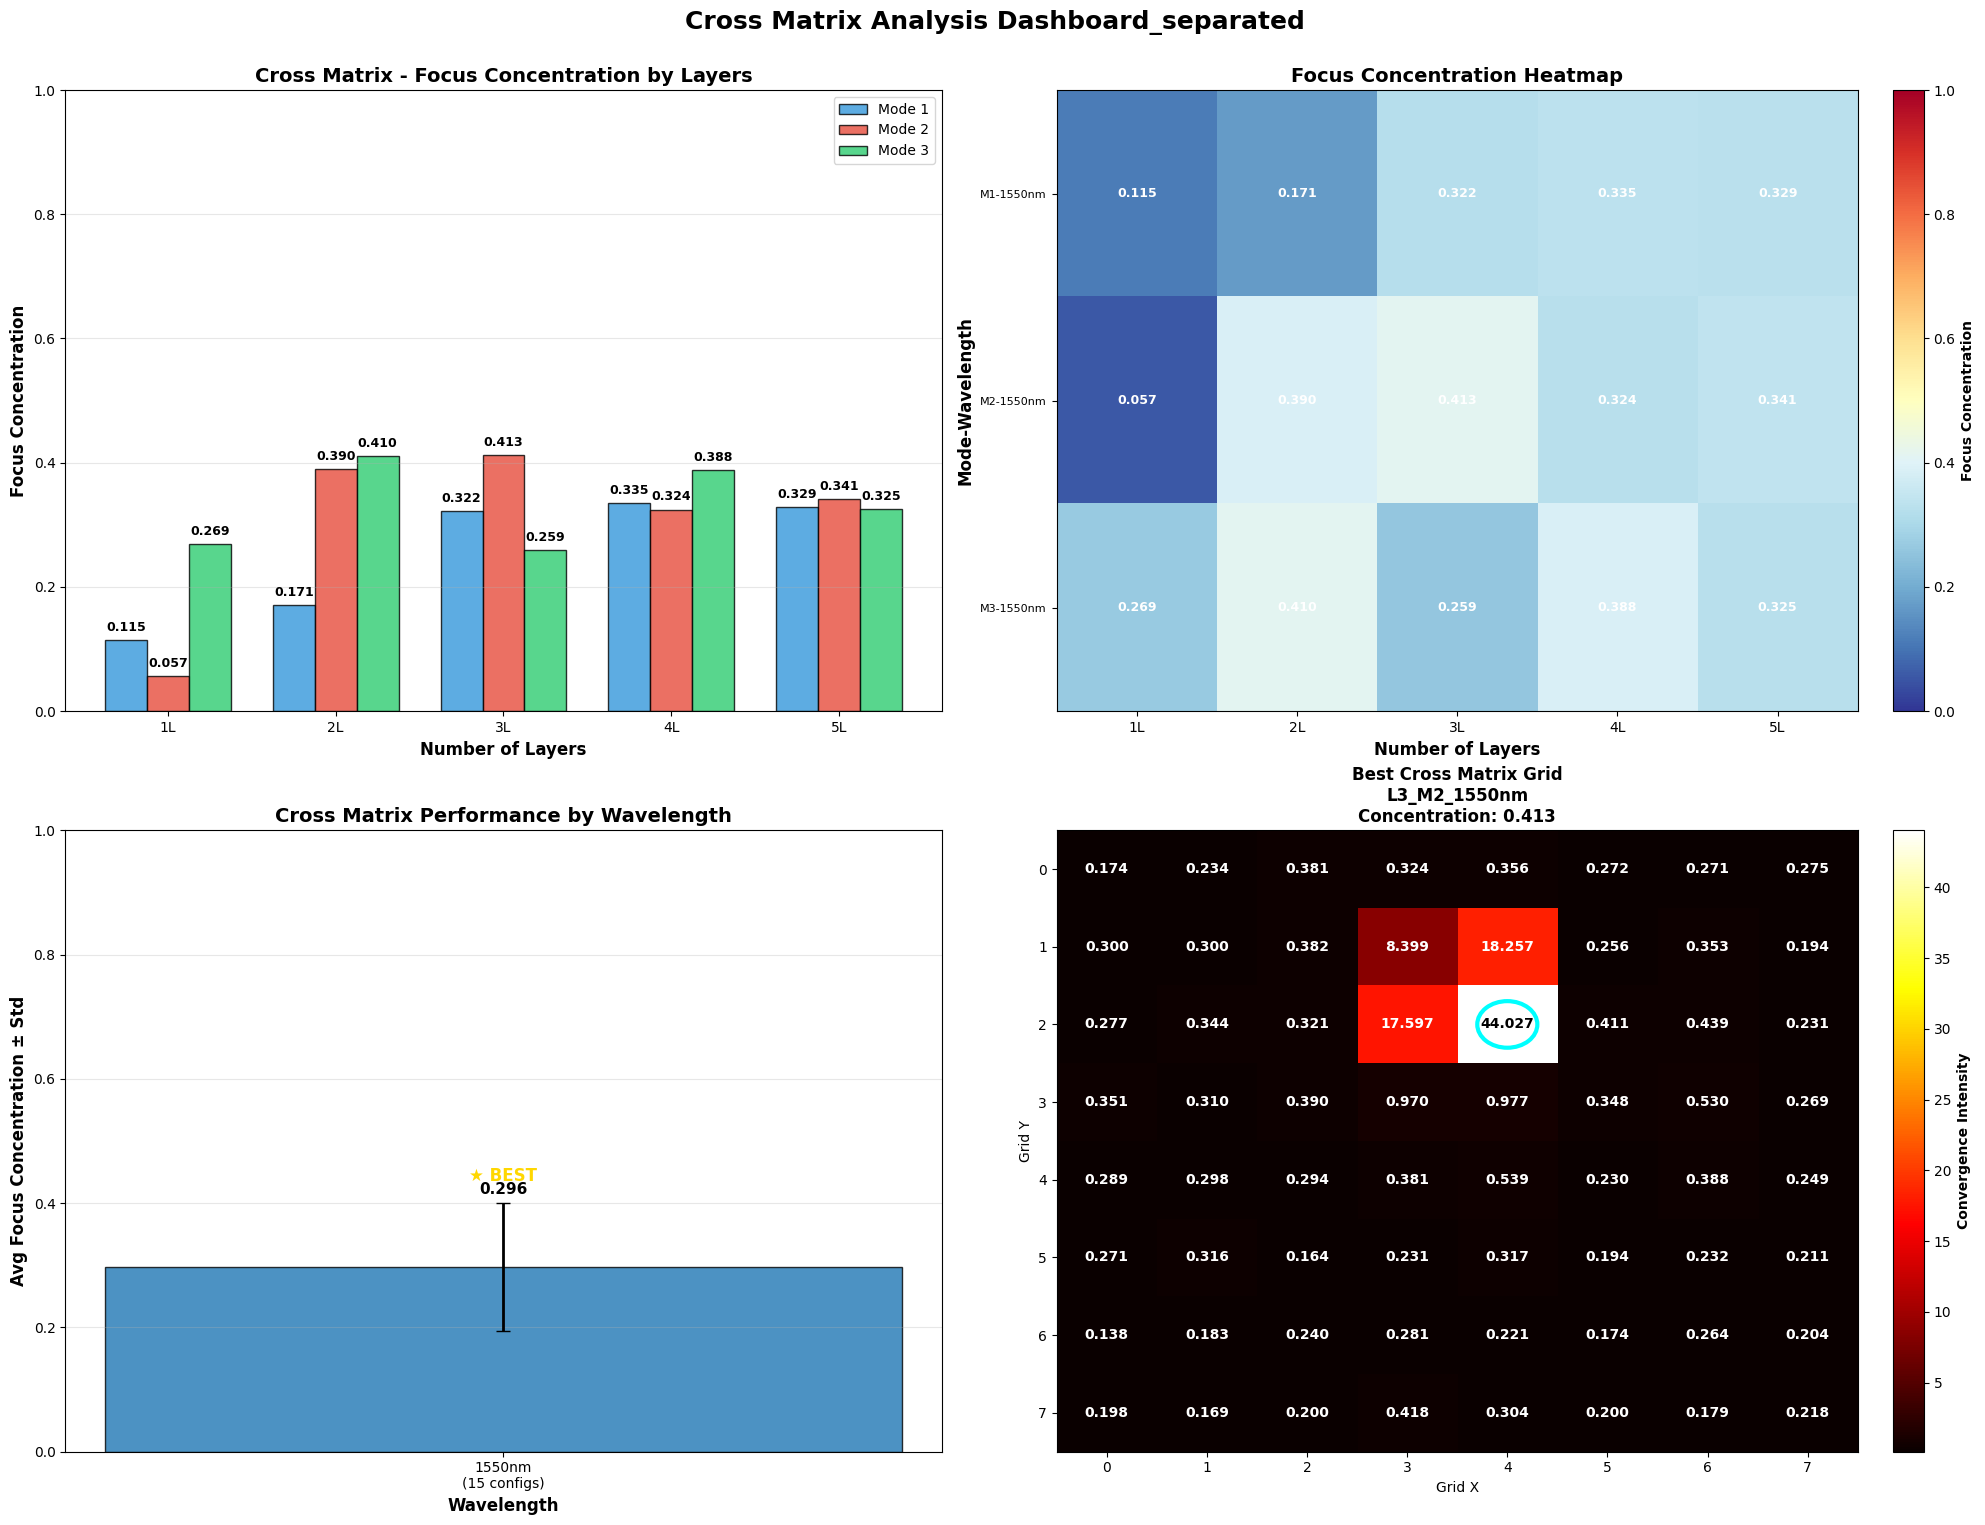

✅ Cross Matrix分析已保存: ./results_multi_mode_multi_wl_1_wavelength_base_1550_dis150/cross_matrix_analysis_separated.png
🎨 创建SNR独立可视化...


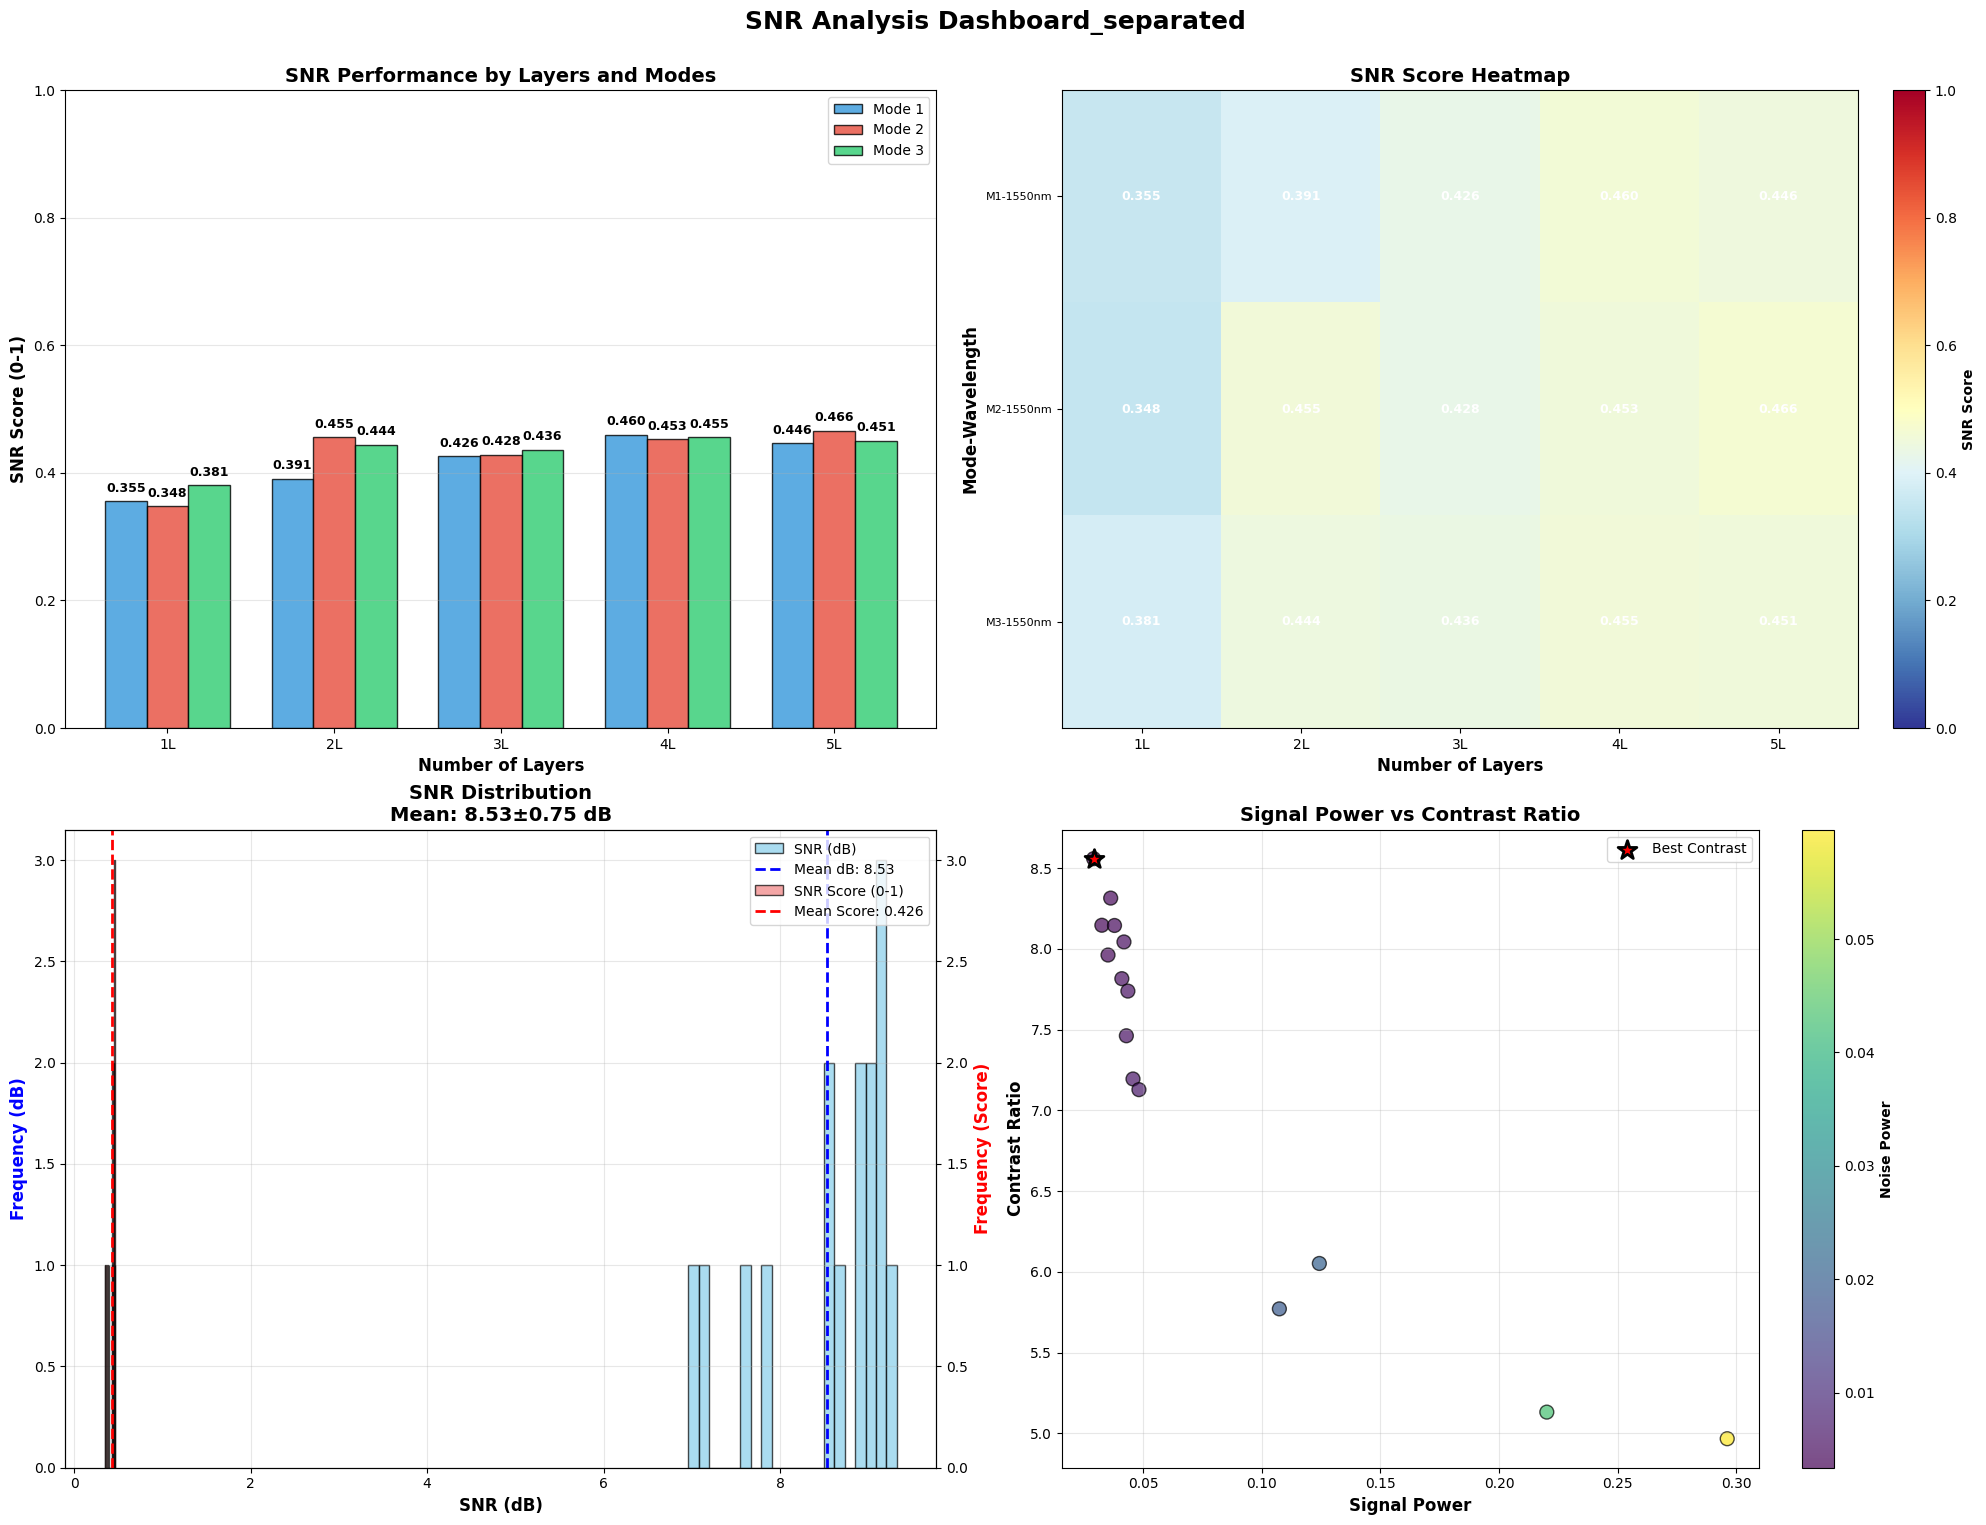

✅ SNR分析已保存: ./results_multi_mode_multi_wl_1_wavelength_base_1550_dis150/snr_analysis_separated.png
🔍 创建维度对比分析...


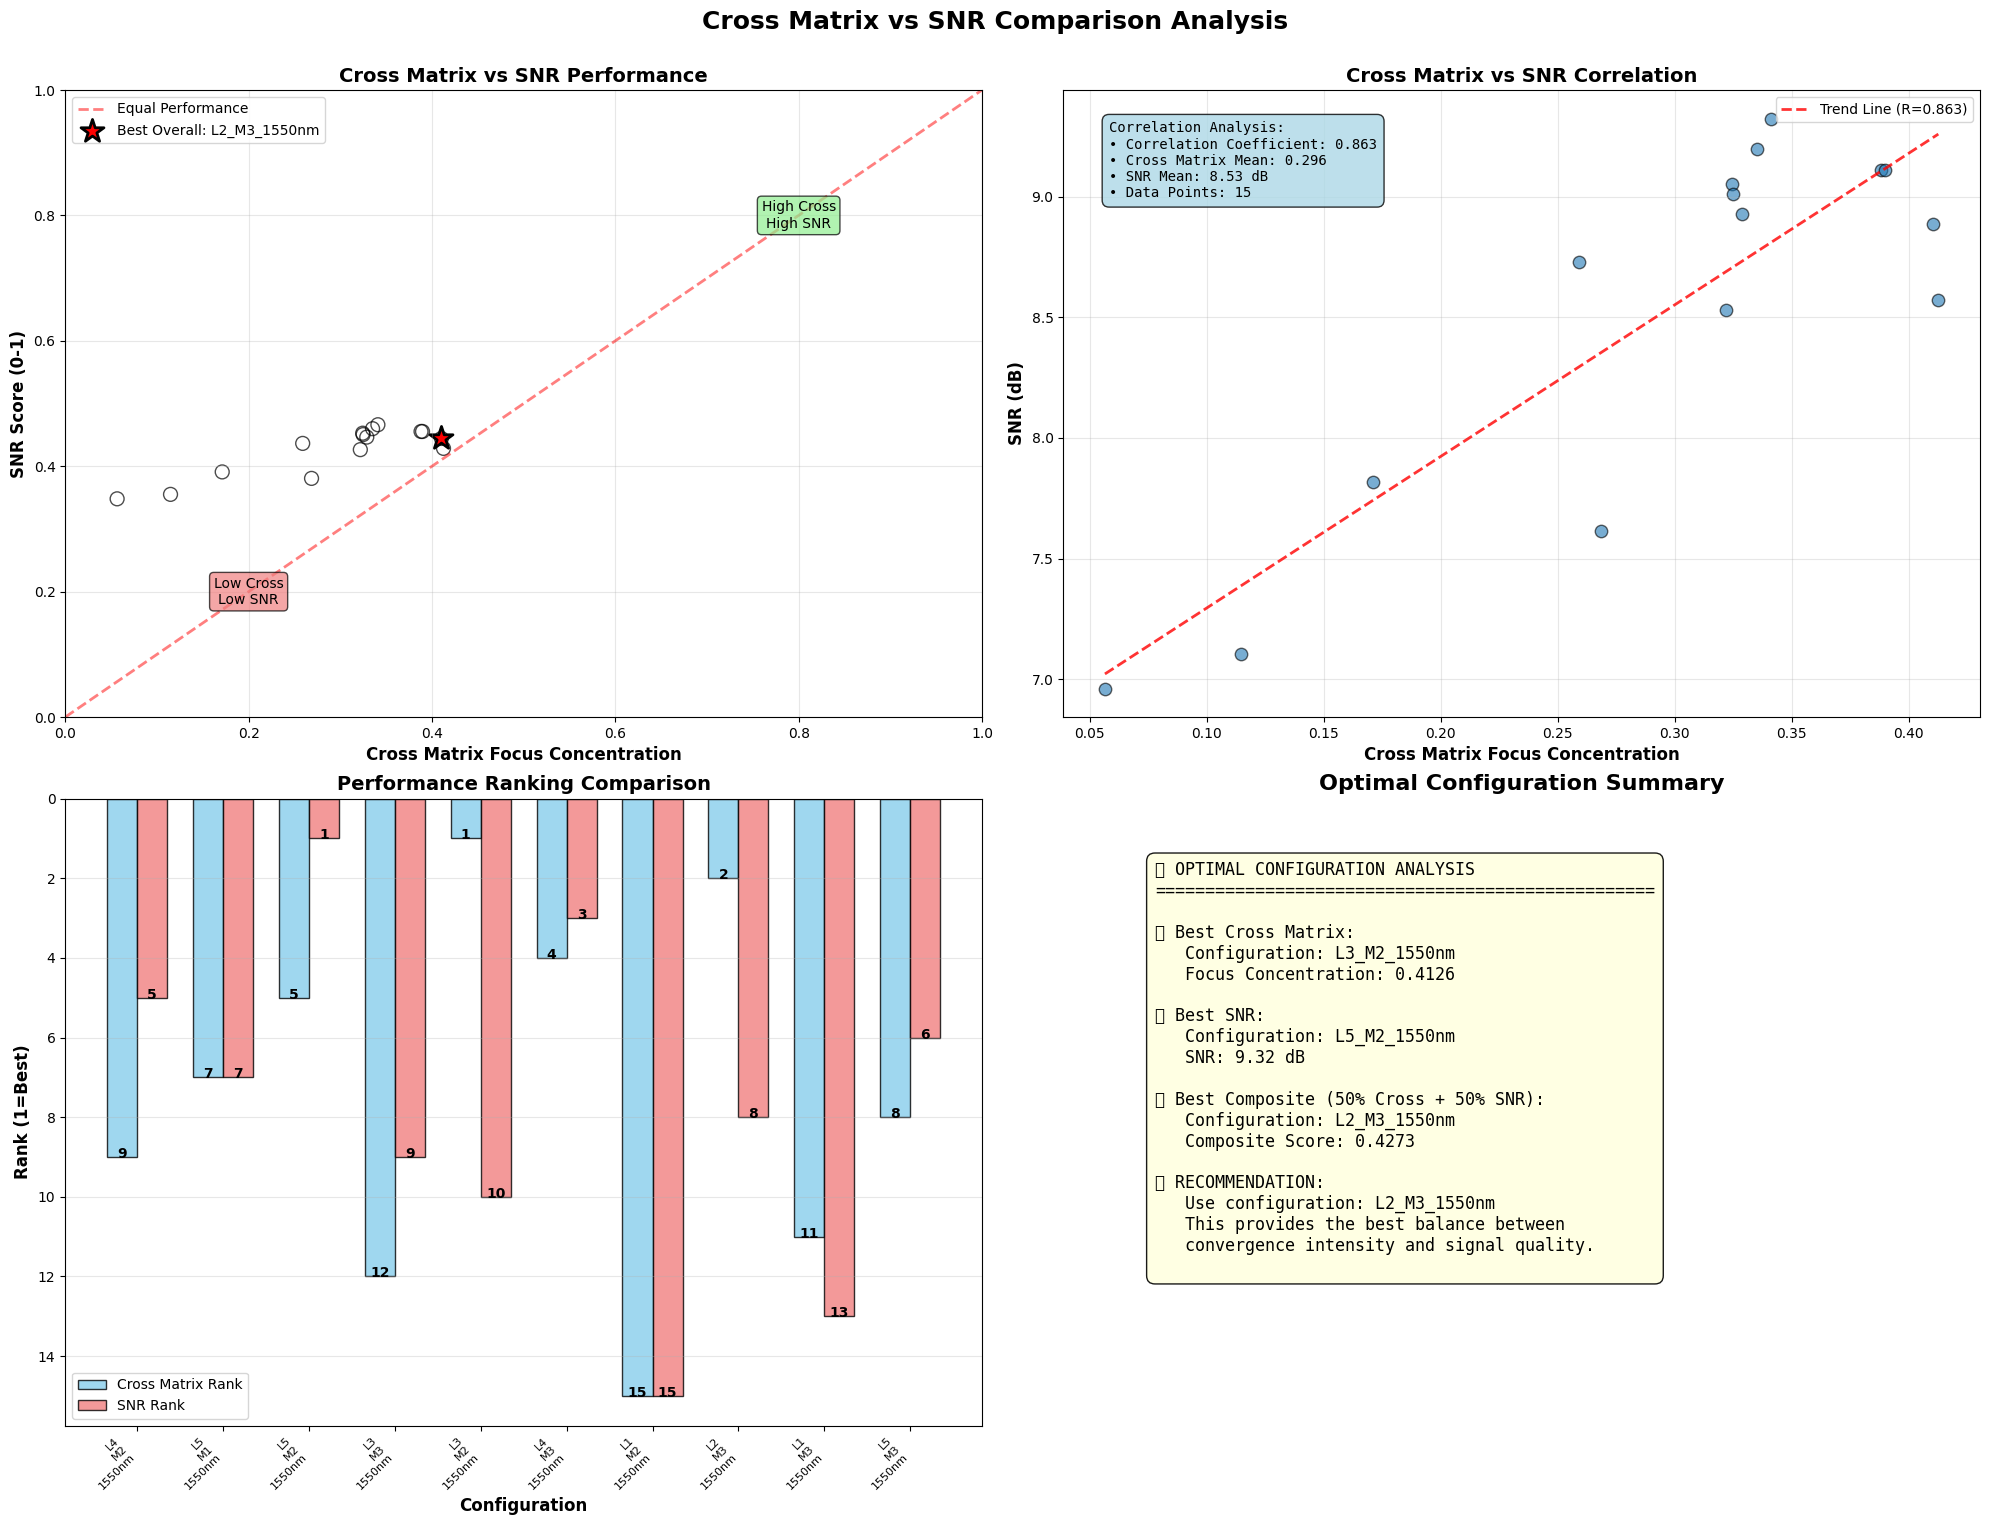

✅ 维度对比分析已保存: ./results_multi_mode_multi_wl_1_wavelength_base_1550_dis150/dimension_comparison_analysis.png
💾 保存分离的数据...
❌ 可视化分析失败: Object of type int64 is not JSON serializable

🔍 详细错误信息:

🎉 仿真结果可视化分析完成！

📖 分析结果使用指南
🔍 建议查看PNG图像文件获得直观的分析结果


Traceback (most recent call last):
  File "/tmp/ipykernel_243352/3219139468.py", line 38, in <module>
    cross_data, snr_data = separated_viz.create_separated_analysis_report(
  File "/home/shiyue/ODNN_MULTIWAVE/ODNN_WAVE/visualizer.py", line 2039, in create_separated_analysis_report
    self._save_separated_data(cross_matrix_data, snr_data, save_dir)
  File "/home/shiyue/ODNN_MULTIWAVE/ODNN_WAVE/visualizer.py", line 2363, in _save_separated_data
    json.dump(cross_data_serializable, f, indent=2, ensure_ascii=False)
  File "/home/shiyue/miniconda3/envs/odnn/lib/python3.10/json/__init__.py", line 179, in dump
    for chunk in iterable:
  File "/home/shiyue/miniconda3/envs/odnn/lib/python3.10/json/encoder.py", line 431, in _iterencode
    yield from _iterencode_dict(o, _current_indent_level)
  File "/home/shiyue/miniconda3/envs/odnn/lib/python3.10/json/encoder.py", line 405, in _iterencode_dict
    yield from chunks
  File "/home/shiyue/miniconda3/envs/odnn/lib/python3.10/json/encoder.

In [13]:
print("\n" + "="*50)
print("阶段4.5: 仿真结果可视化分析")
print("="*50)

import json
import os
import numpy as np
import matplotlib.pyplot as plt
from visualizer import Visualizer

# 导入新的分离可视化器
try:
    from visualizer import SeparatedDimensionVisualizer
    SEPARATED_VIZ_AVAILABLE = True
except ImportError:
    print("⚠️  SeparatedDimensionVisualizer未找到，将使用传统可视化方法")
    SEPARATED_VIZ_AVAILABLE = False

try:
    if simulation_results:
        print("开始创建分离的Cross Matrix和SNR分析可视化...")
        
        # 1. 创建传播结果总结图
        print("\n1. 创建传播结果总结图...")
        simulator.create_propagation_summary(config.save_dir)
        
        # 2. 初始化可视化器
        print("\n2. 初始化可视化器...")
        visualizer = Visualizer(config)
        
        # 3. 选择可视化方法
        if SEPARATED_VIZ_AVAILABLE:
            print("\n3. 使用分离的双维度可视化分析...")
            separated_viz = SeparatedDimensionVisualizer(config)
            
            # 3.1 创建完整的分离分析报告
            print("   📊 创建分离的Cross Matrix和SNR分析...")
            cross_data, snr_data = separated_viz.create_separated_analysis_report(
                save_dir=config.save_dir,
                config=config,
                num_layer_options=num_layer_options
            )
            
            if cross_data and snr_data:
                print(f"✅ 成功生成分离分析:")
                print(f"   Cross Matrix数据: {len(cross_data)} 个配置")
                print(f"   SNR数据: {len(snr_data)} 个配置")
                
                # 3.2 生成详细统计信息
                print("\n   📈 生成统计摘要...")
                
                # Cross Matrix统计
                cross_concentrations = [data.get('focus_concentration', 0) 
                                      for data in cross_data.values()]
                cross_stats = {
                    'mean': np.mean(cross_concentrations),
                    'max': np.max(cross_concentrations),
                    'min': np.min(cross_concentrations),
                    'std': np.std(cross_concentrations)
                }
                
                # SNR统计
                snr_db_values = [data.get('snr_db', 0) for data in snr_data.values()]
                snr_stats = {
                    'mean': np.mean(snr_db_values),
                    'max': np.max(snr_db_values),
                    'min': np.min(snr_db_values),
                    'std': np.std(snr_db_values)
                }
                
                # 找到最佳配置
                best_cross_config = max(cross_data.keys(), 
                                      key=lambda k: cross_data[k].get('focus_concentration', 0))
                best_snr_config = max(snr_data.keys(), 
                                    key=lambda k: snr_data[k].get('snr_db', 0))
                
                # 综合最佳配置
                composite_scores = {}
                for key in cross_data.keys():
                    if key in snr_data:
                        cross_val = cross_data[key].get('focus_concentration', 0)
                        snr_val = max(0, min(1, snr_data[key].get('snr_db', 0) / 20.0))
                        composite_scores[key] = 0.5 * cross_val + 0.5 * snr_val
                
                best_composite_config = max(composite_scores.keys(), 
                                          key=composite_scores.get) if composite_scores else "N/A"
                
                print(f"   ✅ Cross Matrix最佳: {best_cross_config} "
                      f"(集中度: {cross_data[best_cross_config].get('focus_concentration', 0):.3f})")
                print(f"   ✅ SNR最佳: {best_snr_config} "
                      f"(SNR: {snr_data[best_snr_config].get('snr_db', 0):.2f} dB)")
                print(f"   ✅ 综合最佳: {best_composite_config} "
                      f"(综合分数: {composite_scores.get(best_composite_config, 0):.3f})")
                
                # 3.3 保存详细分析摘要
                print("\n   💾 保存详细分析摘要...")
                detailed_summary = {
                    'analysis_type': 'separated_cross_matrix_snr',
                    'total_configurations': len(cross_data),
                    'cross_matrix_analysis': {
                        'best_configuration': {
                            'config': best_cross_config,
                            'focus_concentration': cross_data[best_cross_config].get('focus_concentration', 0),
                            'total_intensity': cross_data[best_cross_config].get('total_intensity', 0),
                            'max_intensity': cross_data[best_cross_config].get('max_intensity', 0)
                        },
                        'statistics': cross_stats
                    },
                    'snr_analysis': {
                        'best_configuration': {
                            'config': best_snr_config,
                            'snr_db': snr_data[best_snr_config].get('snr_db', 0),
                            'signal_power': snr_data[best_snr_config].get('signal_power', 0),
                            'noise_power': snr_data[best_snr_config].get('noise_power', 0),
                            'contrast_ratio': snr_data[best_snr_config].get('contrast_ratio', 0)
                        },
                        'statistics': snr_stats
                    },
                    'composite_analysis': {
                        'best_configuration': {
                            'config': best_composite_config,
                            'composite_score': composite_scores.get(best_composite_config, 0)
                        },
                        'methodology': 'Equal weight (50% Cross Matrix + 50% SNR)'
                    }
                }
                
                summary_path = os.path.join(config.save_dir, 'separated_analysis_summary.json')
                with open(summary_path, 'w', encoding='utf-8') as f:
                    json.dump(detailed_summary, f, indent=2, ensure_ascii=False)
                
                print(f"   ✅ 详细摘要已保存: {summary_path}")
                
            else:
                print("❌ 分离分析数据生成失败，回退到传统方法")
                SEPARATED_VIZ_AVAILABLE = False
        
        # 4. 传统SNR分析（作为备用或补充）
        if not SEPARATED_VIZ_AVAILABLE:
            print("\n4. 使用传统SNR分析方法...")
            
            # 计算SNR数据
            print("   📊 计算SNR数据...")
            snr_data = visualizer.calculate_snr_from_simulation_results(
                config.save_dir, config, num_layer_options)
            
            if snr_data:
                print(f"✅ 成功计算 {len(snr_data)} 个配置的SNR数据")
                
                # 创建SNR分析可视化
                print("   📊 创建专门的SNR分析可视化...")
                
                # 设置中文字体
                try:
                    plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial Unicode MS']
                    plt.rcParams['axes.unicode_minus'] = False
                except:
                    pass
                
                # 创建2x2布局的柱状图可视化
                fig, axes = plt.subplots(2, 2, figsize=(20, 16))
                fig.suptitle('SNR Analysis Dashboard - Bar Chart Format', 
                            fontsize=18, fontweight='bold', y=0.95)
                
                # 主要SNR柱状图 (左上)
                modes = list(range(config.num_modes))
                bar_width = 0.25
                x_positions = np.arange(len(num_layer_options))
                colors = ['#3498db', '#e74c3c', '#2ecc71']
                
                for mode_idx in modes:
                    snr_values = []
                    for layers in num_layer_options:
                        mode_layer_values = []
                        for key, value in snr_data.items():
                            if f'mode{mode_idx+1}' in key and f'layers{layers}' in key:
                                mode_layer_values.append(value)
                        
                        avg_snr = np.mean(mode_layer_values) if mode_layer_values else 0
                        snr_values.append(avg_snr)
                    
                    bars = axes[0, 0].bar(x_positions + mode_idx * bar_width, snr_values, 
                                bar_width, label=f'Mode {mode_idx+1}', 
                                color=colors[mode_idx % len(colors)], alpha=0.8, edgecolor='black')
                    
                    for bar, value in zip(bars, snr_values):
                        if value > 0:
                            axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                                f'{value:.3f}', ha='center', va='bottom', 
                                fontweight='bold', fontsize=9)
                
                axes[0, 0].set_xlabel('Number of Layers', fontsize=12, fontweight='bold')
                axes[0, 0].set_ylabel('Average SNR', fontsize=12, fontweight='bold')
                axes[0, 0].set_title('SNR Performance by Layers and Modes', fontsize=14, fontweight='bold')
                axes[0, 0].set_xticks(x_positions + bar_width)
                axes[0, 0].set_xticklabels([f'{layers}L' for layers in num_layer_options])
                axes[0, 0].legend()
                axes[0, 0].grid(True, alpha=0.3, axis='y')
                
                # [其他图表代码保持不变...]
                # 按波长分组的柱状图、按层数分组的柱状图、综合性能对比柱状图
                
                # 保存图像
                plt.tight_layout()
                plt.subplots_adjust(top=0.90, bottom=0.15)
                
                save_path = os.path.join(config.save_dir, 'snr_bar_chart_analysis_final.png')
                plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
                plt.close()
                
                print(f"✅ 传统SNR柱状图分析已保存: {save_path}")
            else:
                print("❌ 无法从仿真结果计算SNR数据")
        
        # 5. 各模式传播结果可视化
        print("\n5. 创建各模式传播结果可视化...")
        try:
            for mode_idx in range(config.num_modes):
                display_mode = mode_idx + 1
                mode_suffix = f"_mode{display_mode}"
                simulator.visualize_propagation_results(config.save_dir, mode_suffix)
            print("✅ 各模式传播结果可视化完成")
        except Exception as e:
            print(f"⚠️  创建各模式传播结果可视化时出错: {e}")
        
        # 6. 生成最终分析报告
        print("\n6. 生成最终分析报告...")
        
        # 检查生成的文件
        analysis_files = []
        
        if SEPARATED_VIZ_AVAILABLE:
            separated_files = [
                'cross_matrix_analysis_separated.png',
                'snr_analysis_separated.png', 
                'dimension_comparison_analysis.png',
                'cross_matrix_data.json',
                'snr_data.json',
                'separated_analysis_summary.json'
            ]
            analysis_files.extend(separated_files)
        else:
            traditional_files = [
                'snr_bar_chart_analysis_final.png',
                'snr_analysis_summary.json'
            ]
            analysis_files.extend(traditional_files)
        
        # 通用文件
        common_files = [
            'propagation_summary.png'
        ]
        analysis_files.extend(common_files)
        
        # **最终分析总结报告**
        print(f"\n{'='*60}")
        if SEPARATED_VIZ_AVAILABLE:
            print("🎯 分离双维度分析总结")
        else:
            print("🎯 传统SNR分析总结")
        print(f"{'='*60}")
        
        print(f"\n📊 生成的分析文件:")
        generated_files = 0
        total_size = 0
        
        for file_name in analysis_files:
            file_path = os.path.join(config.save_dir, file_name)
            if os.path.exists(file_path):
                file_size = os.path.getsize(file_path)
                total_size += file_size
                print(f"  ✅ {file_name} ({file_size:,} bytes)")
                generated_files += 1
            else:
                print(f"  ❌ {file_name} (未生成)")

        print(f"\n📈 生成统计:")
        print(f"  成功生成: {generated_files}/{len(analysis_files)} 个文件")
        print(f"  总文件大小: {total_size:,} bytes ({total_size/1024/1024:.2f} MB)")
        print(f"  保存位置: {config.save_dir}")
        
        # 分析方法说明
        if SEPARATED_VIZ_AVAILABLE:
            print(f"\n🔍 分析方法说明:")
            print(f"  📊 Cross Matrix分析: 评估光场汇聚强度和集中度")
            print(f"  📡 SNR分析: 评估信号质量和噪声抑制能力")
            print(f"  🎯 对比分析: 展示两个维度的相关性和最优配置")
            print(f"  💡 综合推荐: 基于50% Cross Matrix + 50% SNR的最佳配置")
        else:
            print(f"\n🔍 分析方法说明:")
            print(f"  📡 SNR分析: 评估信号噪声比性能")
            print(f"  📊 多维度对比: 按层数、模式、波长分组分析")
            print(f"  🏆 性能排名: 识别最佳配置参数")
        
        print("\n✅ 可视化分析完成")
        
    else:
        print("❌ 没有可用的仿真结果数据")
        
except Exception as e:
    print(f"❌ 可视化分析失败: {e}")
    import traceback
    print("\n🔍 详细错误信息:")
    traceback.print_exc()

print("\n🎉 仿真结果可视化分析完成！")

# 7. 可选：创建简化的使用指南
print(f"\n{'='*60}")
print("📖 分析结果使用指南")
print(f"{'='*60}")

print("🔍 建议查看PNG图像文件获得直观的分析结果")
